# Grafazo

### Qué va a analizar nuestro grafo?

Analizar "camadas" de gente -> cursaron juntos y les fue parecido en la facu

### Qué queremos responder?

Con quien puedo hacer trabajos prácticos?

### Cómo es el grafo?

- Nodos: usuarios
- Aristas: cursar misma materia mismo cuatri
- Peso: correlacion entre notas(???)

### Ejemplo de conexion:

X y yo cursamos ...

In [1]:
import pandas as pd

df = pd.read_pickle('fiuba-map-data.pickle')
df.sample(3)

Padron      Carrera            Orientacion Final de Carrera materia_id  \
6100   96223  informatica  Sistemas Distribuidos            tesis      71.14   
14328  98227  informatica  Sistemas Distribuidos              tpp      75.15   
17686  96592  informatica  Sistemas Distribuidos              tpp      71.40   

       materia_nota optativas  materia_cuatrimestre  aplazos  
6100           -2.0       NaN                2022.0      NaN  
14328          -2.0       NaN                2022.5      NaN  
17686           4.0       NaN                   NaN      NaN

In [2]:
df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]
df_nodes_metadata = df_nodes_metadata[df_nodes_metadata["aplazos"].notnull() | df_nodes_metadata["optativas"].notnull()]
df_nodes_metadata = df_nodes_metadata.groupby(["Padron", "Carrera"], as_index=False).first()

df_nodes = df[["Padron", "Carrera", "Orientacion", "Final de Carrera"]]
df_nodes = df_nodes.drop_duplicates()
df_nodes = df_nodes.merge(df_nodes_metadata, how="outer")
df_nodes.set_index("Padron", inplace=True)
display(df_nodes.sample(3))

from itertools import combinations
df_edges = (df[df['materia_cuatrimestre'].notnull()]
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

df_edges = df_edges.reset_index()
df_edges[['src', 'dst']] = df_edges['Usuarios'].tolist()
df_edges[['src_padron', 'src_nota']] = df_edges['src'].tolist()
df_edges[['dst_padron', 'dst_nota']] = df_edges['dst'].tolist()
df_edges = df_edges[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]
display(df_edges.sample(3))

/tmp/ipykernel_11915/1168196422.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]


Carrera                     Orientacion Final de Carrera  \
Padron                                                                         
96029           informatica  Gestión Industrial de Sistemas              tpp   
106308          informatica           Sistemas Distribuidos              NaN   
42951549_ideal  informatica                             NaN              NaN   

                                                        optativas  aplazos  
Padron                                                                      
96029                                                         NaN      NaN  
106308          [{'id': 1, 'nombre': 'Materia Optativa', 'cred...      NaN  
42951549_ideal                                                NaN      NaN

/tmp/ipykernel_11915/1168196422.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


src_padron dst_padron  materia_cuatrimestre materia_id src_nota  \
40513       91378      95159                2020.5      71.14      4.0   
132789     108645     102649                2022.0      78.xx      8.0   
8567       103775     104258                2019.5      61.08      8.0   

       dst_nota  
40513       4.0  
132789     -2.0  
8567        9.0

In [3]:
import networkx as nx
G = nx.from_pandas_edgelist(df_edges, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

nx.set_node_attributes(G, df_nodes.to_dict('index'))
print(G)

MultiGraph with 396 nodes and 133548 edges


In [4]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

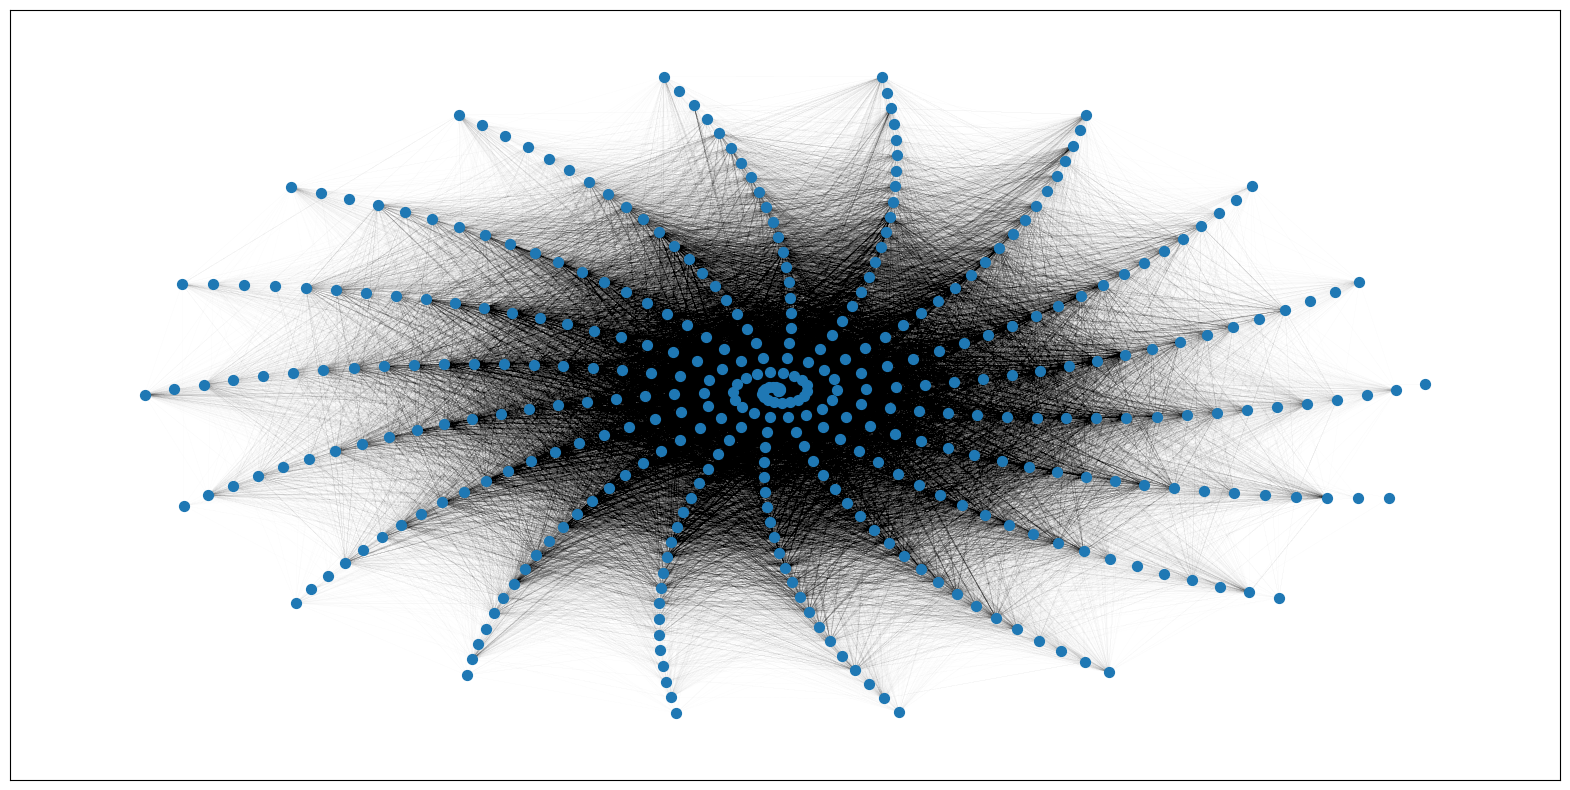

In [5]:
# Again!
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.spiral_layout(G), width=0.005, node_size=50, with_labels=False)

In [6]:
# # Solo como demo: ahora veamos el grafo, pero dibujemos todas las aristas
# # Robadisimo de: https://stackoverflow.com/a/60638452
# pos = nx.random_layout(G)
# nx.draw_networkx_nodes(G, pos)
# ax = plt.gca()
# for e in G.edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="-", color="0.5",
#                                 connectionstyle="arc3,rad=rr".replace('rr',str(0.3*e[2]))),
#                 )
# plt.axis('off')
# plt.show()

## Stats generales del grafo

In [7]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 4
  El grado promedio de la red: 674.48
  TODO: Los allegados promedio de la red: 
  Puentes globales: []



## Comunidades

In [8]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

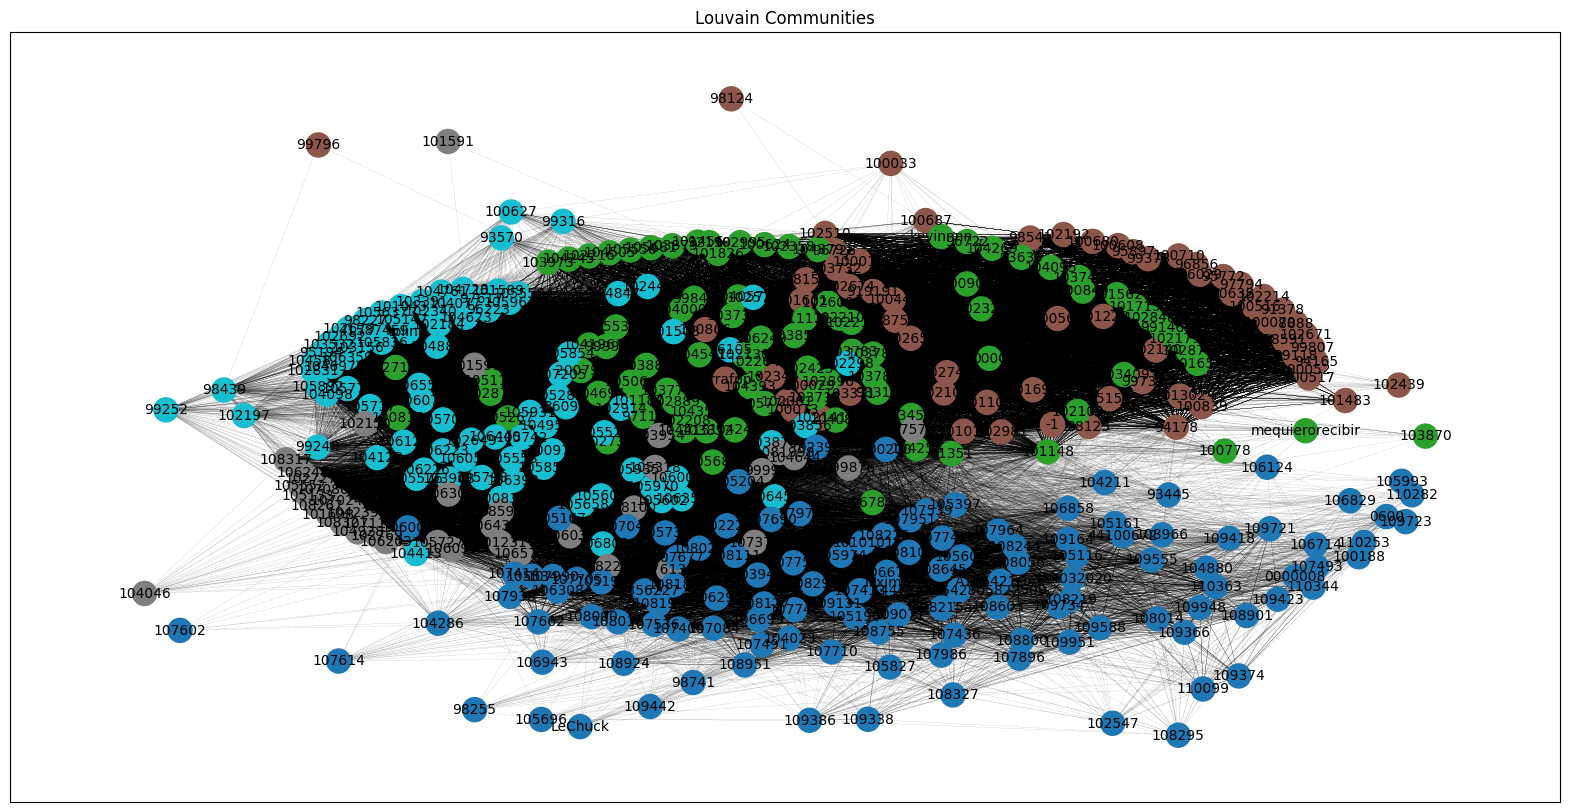

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

### Evaluación de comunidades por "generación"
¿Existe correlación entre la distribución de padrones y la comunidad? De tal forma que las comunidades sean por camadas o "generacionales"

In [10]:
louvain_padrones = []
for i, comunidad in enumerate(louvain):
    for padron in comunidad:
        louvain_padrones.append((padron, i))
df_comunidades = pd.DataFrame(louvain_padrones, columns=["padron", "comunidad"])
df_comunidades["comunidad"].value_counts()

4    121
1     87
2     85
0     65
3     38
Name: comunidad, dtype: int64

In [11]:
import seaborn as sns

# len patch for overflow
df = df_comunidades[(df_comunidades['padron'].str.isdigit()) & (df_comunidades["padron"].str.len() < 10)].copy()
df["padron"] = df["padron"].astype(int)

# remove outliers by percentiles, stolen from https://stackoverflow.com/a/59366409
Q1 = df["padron"].quantile(0.10)
Q3 = df["padron"].quantile(0.90)
IQR = Q3 - Q1
df_comunidades = df[~((df["padron"] < (Q1 - 1.5 * IQR)) |(df["padron"] > (Q3 + 1.5 * IQR)))]

Se puede observar una mínima correlación considerando el intervalo más frecuente de cada comunidad

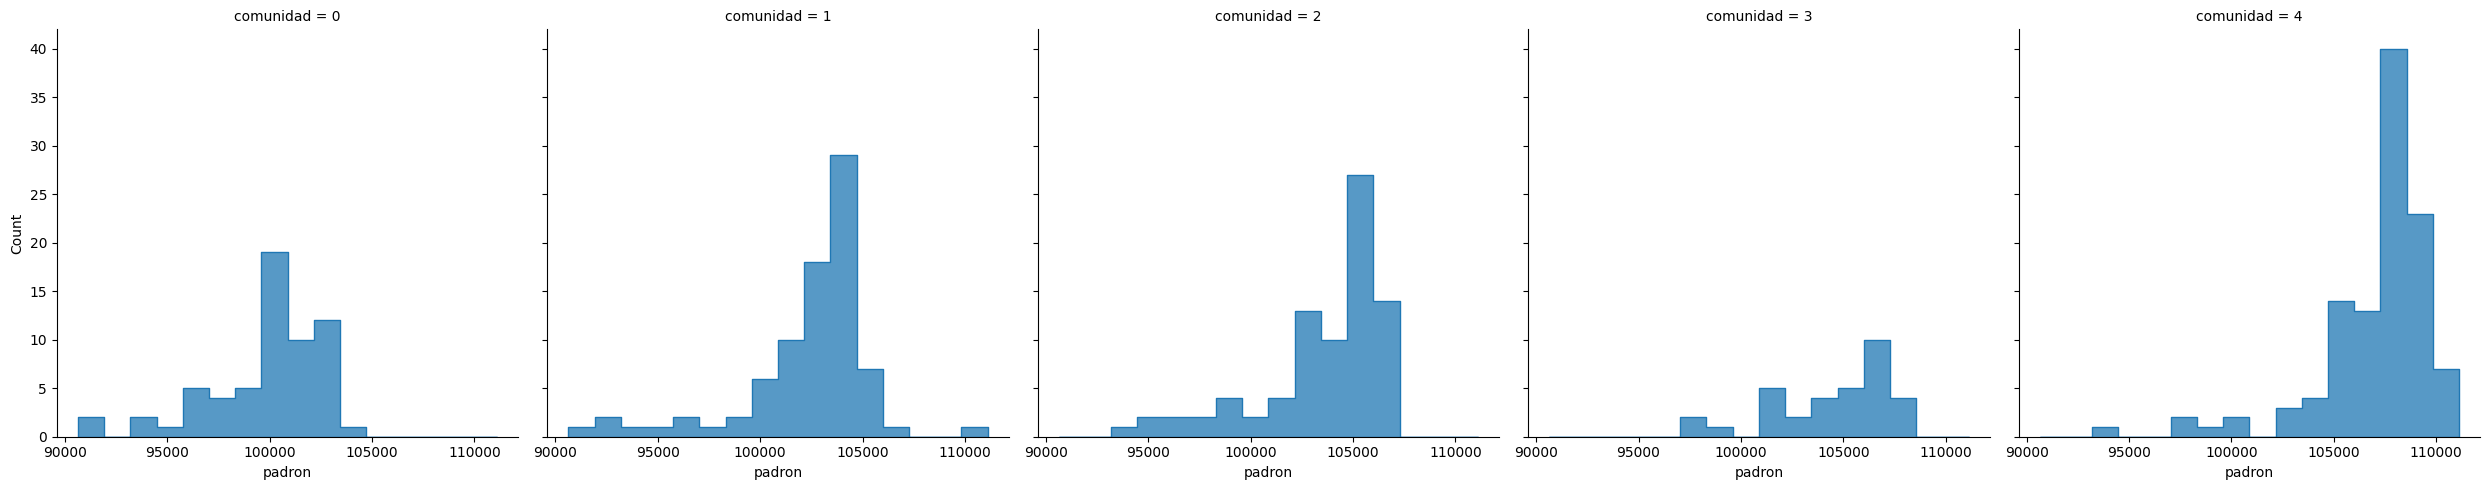

In [12]:
# TODO: display as rows instead of columns, perhaps?
# TODO: play with the "stat" parameter. another interesting one is the "density" parameter
g = sns.displot(
    df_comunidades,
    x="padron",
    col="comunidad",
    element="step",
    stat="count",
    common_norm=False,
)

### Materias y cuatrimestres en común
Se puede aproximar a una mejor noción de _camada_ que simplemente tomando el padrón, tomando el conjunto de materias/cuatrimestre más populares por comunidad.

Las comunidades considerando dicha métrica, se observan personas que:

- Entraron a la facultad en el 2019c1
- Cursaron Taller de Programación en el 2020c1
- Entraron a la facultad en el 2020c1
- Tienen planificado hacer Base de Datos y Legislación en el 2023c1 (comunidad más chica)
- Entraron a la facultad en el 2021c1

In [13]:
df = df_comunidades.copy()
df['padron'] = df['padron'].astype(str)
df_src = pd.merge(df_edges, df, left_on='src_padron', right_on='padron')
df_dst = pd.merge(df_edges, df, left_on='dst_padron', right_on='padron')
(
    pd
        .concat([df_src, df_dst])
        .groupby(['comunidad', 'materia_cuatrimestre', 'materia_id'])
        .agg(count=('src_padron', 'count'))
        .sort_values('count', ascending=False)
        .reset_index()
        .groupby('comunidad')   # obtener top 3 materias/cuatrimestres por comunidad
        .head(3)
        .sort_values(['comunidad', 'count'])
)

comunidad  materia_cuatrimestre materia_id  count
25          0                2019.5      66.70   2160
26          0                2020.0      75.08   2160
23          0                2019.0      62.03   2205
16          1                2019.0      75.40   2700
14          1                2019.0      61.03   2805
10          1                2019.0      62.01   3132
2           2                2021.0      75.07   3894
1           2                2020.5      75.41   3960
0           2                2020.0      75.40   4347
58          3                2023.0      75.15   1170
57          3                2022.0      75.08   1196
55          3                2023.0      71.40   1320
60          4                2022.0      75.07   1120
53          4                2021.0      75.40   1330
51          4                2021.5      75.41   1360

## Subcomunidades

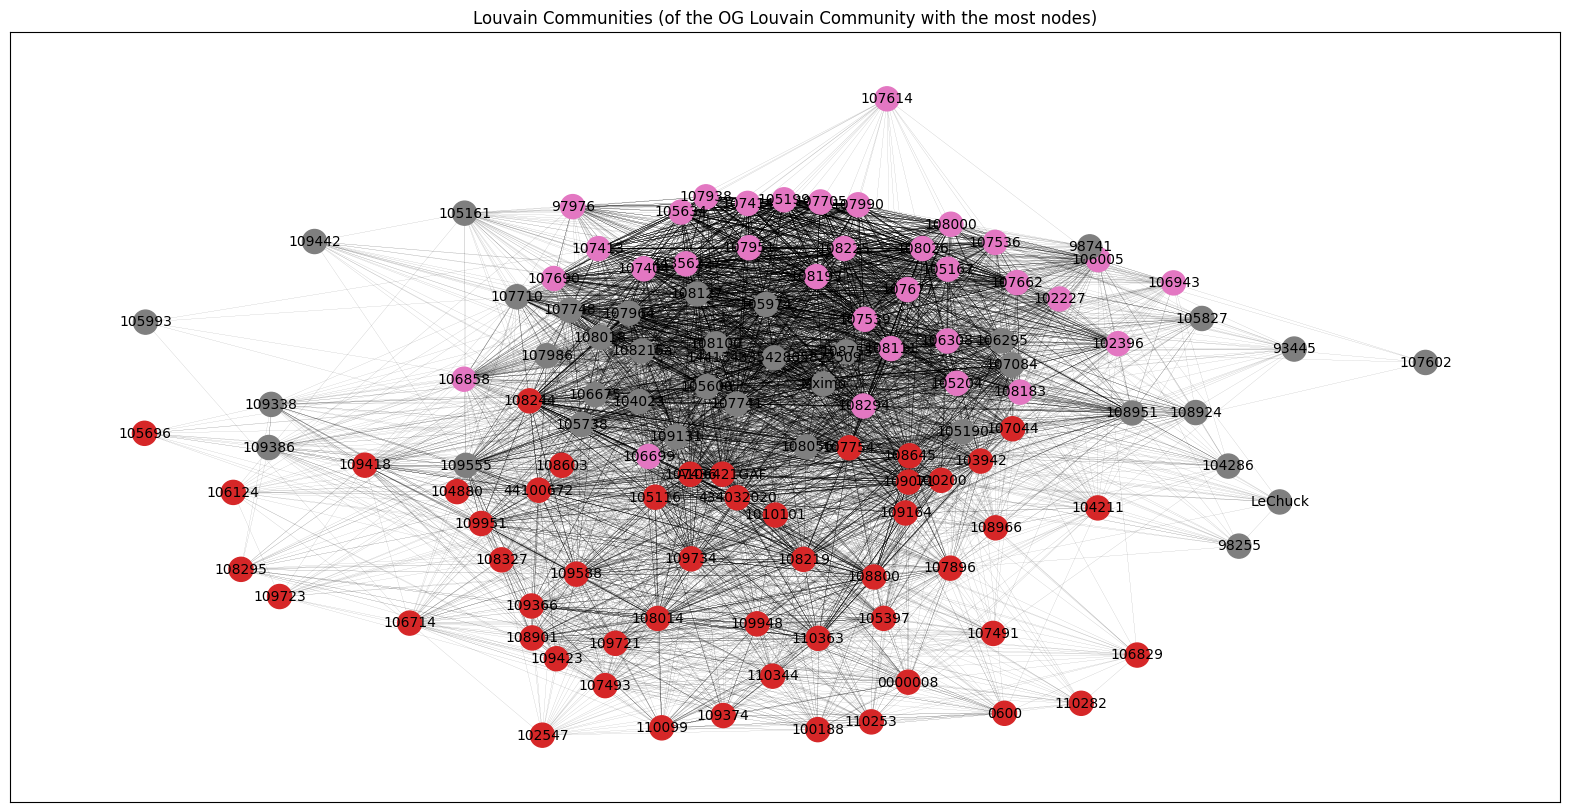

In [14]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [15]:
subnetwork_louvain

[{'102227',
  '102396',
  '105167',
  '105199',
  '105204',
  '105634',
  '106005',
  '106308',
  '106699',
  '106858',
  '106943',
  '107404',
  '107413',
  '107414',
  '107536',
  '107539',
  '107614',
  '107662',
  '107677',
  '107690',
  '107705',
  '107938',
  '107951',
  '107990',
  '108000',
  '108026',
  '108111',
  '108183',
  '108193',
  '108225',
  '108294',
  '44356227',
  '97976'},
 {'104023',
  '104286',
  '105161',
  '105190',
  '105600',
  '105738',
  '105827',
  '105974',
  '105993',
  '106295',
  '106675',
  '107084',
  '107602',
  '107710',
  '107741',
  '107748',
  '107964',
  '107986',
  '108018',
  '108056',
  '108100',
  '108127',
  '108215a',
  '108755',
  '108924',
  '108951',
  '109131',
  '109338',
  '109386',
  '109442',
  '109555',
  '14413433542805822509',
  '93445',
  '98255',
  '98741',
  'LeChuck',
  'Mximo'},
 {'0000008',
  '0600',
  '100188',
  '100200',
  '1010101',
  '102547',
  '103942',
  '104211',
  '104880',
  '105116',
  '105397',
  '105696',
 

In [16]:
# todo: usar graphrole y rolx

In [17]:
# todo: ejercicio 5 de parcialito 3

In [18]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [19]:
# - Los 3 notebooks de grafos hacen exactamente el mismo analisis, pero con distintas conclusiones
# - Cada notebook de grafo devuelve un __algo__ que sea util y valioso para el usuario (despues vemos como se lo proveemos)
#   y la respuesta puede ser o de comunidad o de roles, hay que ver que es lo adecuado.